In [8]:
# import packages
import os, pickle, csv, numpy as np
from collections import defaultdict
from pathlib import Path
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

In [10]:
# Term Volatility Across 12 Months

# Adjust these paths
EMB_ROOT   = Path("./embeddings")          # parent of 2023-01/, … 2023-12/
MONTH_KEYS = ["2023-01","2023-02","2023-03","2023-04",
              "2023-05","2023-06","2023-07","2023-08",
              "2023-09","2023-10","2023-11","2023-12"]

# outputs (will be small):
OUT_TSV    = Path("volatility.tsv")
OUT_PICKLE = Path("word_monthly_vecs.pkl")

#### Load each month’s `word_to_avg_emb.pkl`

In [13]:
# word -> [12 vectors or None]
word_series = defaultdict(lambda: [None]*len(MONTH_KEYS))

for idx, mkey in enumerate(MONTH_KEYS):
    pkl_path = EMB_ROOT / mkey / "word_to_avg_emb.pkl"
    if not pkl_path.exists():
        raise FileNotFoundError(pkl_path)
    with pkl_path.open("rb") as f:
        w2v = pickle.load(f)
    for w, v in w2v.items():
        word_series[w.lower()][idx] = v.astype(np.float32)

print("Snapshots loaded:", len(MONTH_KEYS))
print("Distinct words  :", len(word_series))

Snapshots loaded: 12
Distinct words  : 241875


#### Compute a simple volatility metric

For each token **w**

$$\text{Vol}(w) = \frac{1}{N-1}\sum_{m=1}^{N-1} \left(1-\cos(e_w^{(m)}, e_w^{(m+1)})\right)$$

Where:
- $w$ = target word
- $N$ = total number of time periods  
- $e_w^{(m)}$ = embedding vector for word $w$ at time period $m$
- $\cos(e_w^{(m)}, e_w^{(m+1)})$ = cosine similarity between consecutive embeddings

In [15]:
def mean_consecutive_drift(vec_list):
    prev, total, count = None, 0.0, 0
    for v in vec_list:
        if v is None:
            prev = None
            continue
        if prev is not None:
            total += 1 - float(cosine_similarity(prev.reshape(1,-1),
                                                  v.reshape(1,-1))[0,0])  # 1 - cosine_similarity
            count += 1
        prev = v
    return total / count if count else 0.0

volatility = {w: mean_consecutive_drift(v) for w, v in word_series.items()}
print("Computed volatility for", len(volatility), "tokens")

Computed volatility for 241875 tokens


#### Save the results and inspect the most volatile tokens

In [17]:
# convert defaultdict -> normal dict so no lambda gets pickled
word_series_plain = {k: v for k, v in word_series.items()}

# TSV
with OUT_TSV.open("w", newline="", encoding="utf-8") as f:
    writer = csv.writer(f, delimiter="\t")
    writer.writerow(["word", "volatility"])
    for w, s in sorted(volatility.items(), key=lambda x: x[1], reverse=True):
        writer.writerow([w, f"{s:.6f}"])
print("TSV written →", OUT_TSV)

# Pickle
with OUT_PICKLE.open("wb") as f:
    pickle.dump(word_series_plain, f, protocol=pickle.HIGHEST_PROTOCOL)
print("word-series pickle →", OUT_PICKLE)

# quick preview
for w, s in sorted(volatility.items(), key=lambda x: x[1], reverse=True)[:15]:
    print(f"{s:.3f}  {w}")

TSV written → volatility.tsv
word-series pickle → word_monthly_vecs.pkl
1.129  winz
1.055  darknet_hacker_spammer
1.050  oss
1.022  bulldog
1.021  codiguin
1.020  competitor
1.019  vis
1.018  peacock
1.018  richever
1.016  clancy
1.015  vaz
1.014  hampstead
1.013  infraudorgz
1.012  lupton
1.011  veiga


#### Visualise drift for chosen keywords

In [19]:
EXCLUDE_WORDS = {
    # Articles
    'a', 'an', 'the',
    # Common prepositions
    'in', 'on', 'at', 'by', 'for', 'with', 'from', 'to', 'of', 'into', 'onto', 
    'upon', 'over', 'under', 'above', 'below', 'between', 'among', 'through',
    'during', 'before', 'after', 'since', 'until', 'within', 'without', 'about',
    'against', 'across', 'around', 'behind', 'beside', 'beyond', 'near', 'off',
    # Common stopwords
    'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'your',
    'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she',
    'her', 'hers', 'herself', 'it', 'its', 'itself', 'they', 'them', 'their',
    'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that',
    'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being',
    'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'will',
    'would', 'should', 'could', 'can', 'may', 'might', 'must', 'shall',
    'and', 'but', 'or', 'nor', 'not', 'no', 'yes', 'so', 'if', 'then', 'else',
    'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',
    'most', 'other', 'some', 'such', 'only', 'own', 'same', 'than', 'too',
    'very', 'just', 'now'
}

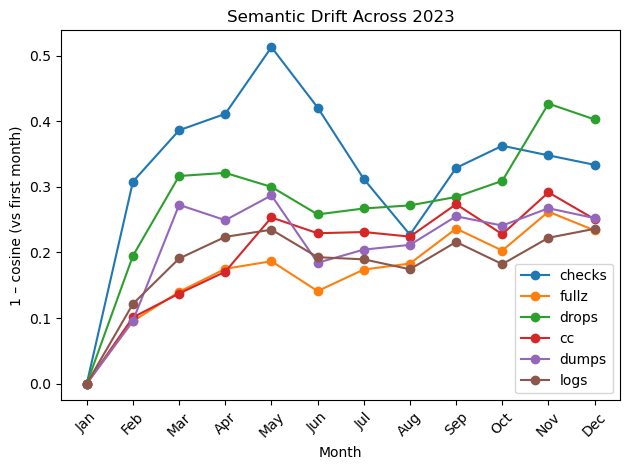

In [20]:
# Change the list below to any words of interest

ALL_WORDS = ["checks", "fullz", "drops", "cc", "dumps", "logs"]   # edit your words
WORDS = [word for word in ALL_WORDS if word.lower() not in EXCLUDE_WORDS]
MONTH_LABELS = ["Jan","Feb","Mar","Apr","May","Jun",
                "Jul","Aug","Sep","Oct","Nov","Dec"]

with OUT_PICKLE.open("rb") as f:
    series = pickle.load(f)

for word in WORDS:
    vecs = series.get(word.lower())
    if vecs is None:
        print(f"'{word}' not in vocab"); continue

    # distance to first available month
    base_idx = next(i for i,v in enumerate(vecs) if v is not None)
    base_vec = vecs[base_idx].reshape(1,-1)
    y = [np.nan]*12
    for m, v in enumerate(vecs):
        if v is not None:
            y[m] = 1 - float(cosine_similarity(base_vec,
                                               v.reshape(1,-1))[0,0])
    plt.plot(MONTH_LABELS, y, marker="o", label=word)

plt.xticks(rotation=45)
plt.xlabel("Month")
plt.ylabel("1 – cosine (vs first month)")
plt.title("Semantic Drift Across 2023")
plt.legend()
plt.tight_layout()
plt.show()

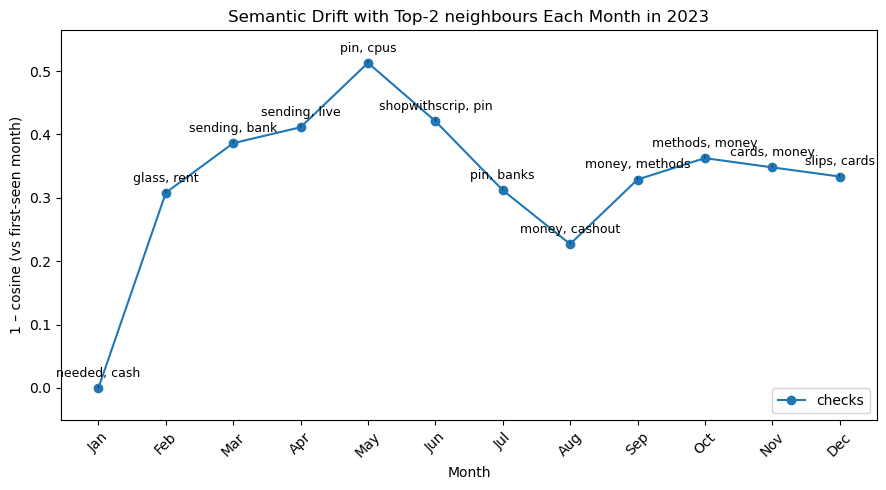

In [21]:
# Enhanced drift plot with neighbour annotations

from itertools import islice

WORDS         = ["checks"]   # keywords to plot
MONTH_LABELS  = ["Jan","Feb","Mar","Apr","May","Jun",
                 "Jul","Aug","Sep","Oct","Nov","Dec"]
NEIGHBORS_K   = 2
offset_base   = 4        # baseline y-offset in points
offset_step   = 10       # extra offset per word to avoid overlap
NEIGH_CACHE   = {}       # cache: month_key → (vocab, matrix)

def top_k_neigh(vec, month_key, k=2):
    if month_key not in NEIGH_CACHE:
        pkl = EMB_ROOT / month_key / "word_to_avg_emb.pkl"
        with pkl.open("rb") as f:
            w2v = pickle.load(f)
        vocab  = list(w2v.keys())
        matrix = np.vstack([w2v[w] for w in vocab])
        NEIGH_CACHE[month_key] = (vocab, matrix)
    vocab, matrix = NEIGH_CACHE[month_key]
    sims  = cosine_similarity(vec.reshape(1,-1), matrix)[0]
    order = sims.argsort()[::-1]
    # Filter out stopwords, prepositions, articles
    filtered_neighbors = []
    for i in order:
        word = vocab[i]
        if (sims[i] < 0.9999 and 
            word.lower() not in EXCLUDE_WORDS and 
            len(word) > 2):  # also exclude very short words
            filtered_neighbors.append(word)
            if len(filtered_neighbors) >= k:
                break
    return filtered_neighbors
    #return list(islice((vocab[i] for i in order if sims[i] < 0.9999), k))

plt.figure(figsize=(9,5))

for w_idx, word in enumerate(WORDS):
    key   = word.lower()
    vecs  = series.get(key)
    if not vecs:
        print(f"'{word}' not found"); continue

    # baseline = first available month
    base_idx = next(i for i,v in enumerate(vecs) if v is not None)
    base_vec = vecs[base_idx].reshape(1,-1)

    y_vals = []
    for v in vecs:
        if v is None:
            y_vals.append(np.nan)
        else:
            y_vals.append(1 - float(cosine_similarity(base_vec,
                                    v.reshape(1,-1))[0,0]))

    # plot the drift line
    plt.plot(MONTH_LABELS, y_vals, marker="o", label=word)

    # add neighbour labels for each existing month
    for m_idx, (dist, v) in enumerate(zip(y_vals, vecs)):
        if np.isnan(dist):          # word absent
            continue
        neigh = top_k_neigh(v, MONTH_KEYS[m_idx], k=NEIGHBORS_K)
        label = ", ".join(neigh)
        
        # Alternate above/below based on word index
        if w_idx % 2 == 0:  # First word (checks) - above
            y_offset = offset_base + w_idx*offset_step
        else:  # Second word (fullz) - below
            y_offset = -(offset_base + w_idx*offset_step)
        plt.annotate(label,
                     xy=(MONTH_LABELS[m_idx], dist),
                     xytext=(0, offset_base + y_offset),
                     textcoords="offset points",
                     ha='center', fontsize=9,
                     arrowprops=dict(arrowstyle="-", lw=.4))

plt.xticks(rotation=45)
plt.xlabel("Month")
plt.ylabel("1 – cosine (vs first-seen month)")
plt.title("Semantic Drift with Top-2 neighbours Each Month in 2023")
plt.legend(loc="lower right")
plt.tight_layout()
plt.margins(y=0.1)
plt.show()

#### ---Example Optional Steps to Calculate Other Measures---

#### Frequency-weighted volatility 

In [36]:
import math, pickle

FREQ_PKL = Path("monthly_freqs.pkl")    # adjust if you have this file

if FREQ_PKL.exists():
    with FREQ_PKL.open("rb") as f:
        freqs = pickle.load(f)          # dict[word] -> list[12 ints]

    fw_vol = {}
    for w, vecs in word_series.items():
        prev, s, wsum = None, 0.0, 0.0
        for i, v in enumerate(vecs):
            if v is None or w not in freqs:        # skip if no vector or no freq
                prev = None
                continue
            if prev is not None:
                dist = 1 - float(cosine_similarity(prev.reshape(1,-1),
                                                     v.reshape(1,-1))[0,0])
                weight = math.log(freqs[w][i] + 1)
                s += dist * weight
                wsum += weight
            prev = v
        if wsum:
            fw_vol[w] = s / wsum

    top_fw = sorted(fw_vol.items(), key=lambda x: x[1], reverse=True)[:15]
    print("\nTop 15 frequency-weighted volatile terms:")
    for w, s in top_fw:
        print(f"{s:.3f}  {w}")
else:
    print("monthly_freqs.pkl not found – skip frequency-weighted metric.")

monthly_freqs.pkl not found – skip frequency-weighted metric.


#### Alternative metric – maximum single-month jump 

In [38]:
max_jump = {}
for w, vecs in word_series.items():
    prev, best = None, 0.0
    for v in vecs:
        if v is None:
            prev = None
            continue
        if prev is not None:
            dist = 1 - float(cosine_similarity(prev.reshape(1,-1),
                                               v.reshape(1,-1))[0,0])
            best = max(best, dist)
        prev = v
    max_jump[w] = best

for w, s in sorted(max_jump.items(), key=lambda x: x[1], reverse=True)[:15]:
    print(f"{s:.3f}  {w}")

1.129  winz
1.095  willow
1.067  boneca
1.058  animes
1.055  tesla
1.055  darknet_hacker_spammer
1.054  lucaslimardn
1.053  blinders
1.050  oss
1.046  din
1.046  leaf
1.043  snickers
1.042  karol
1.041  micro
1.040  tres


#### Export drift curves to CSV

In [40]:
import csv

EXPORT_WORDS = ["checks", "fullz", "drops", "cc"]
CSV_FILE     = "drift_curves.csv"

rows = []
for word in EXPORT_WORDS:
    vecs = word_series.get(word.lower())
    if not vecs:
        continue
    # baseline = first month where word exists
    base_idx = next(i for i,v in enumerate(vecs) if v is not None)
    base_vec = vecs[base_idx].reshape(1,-1)
    for m, v in enumerate(vecs):
        if v is None:
            continue
        dist = 1 - float(cosine_similarity(base_vec, v.reshape(1,-1))[0,0])
        rows.append({"query": word,
                     "month": MONTH_KEYS[m],
                     "dist": round(dist, 6)})

with open(CSV_FILE, "w", newline="", encoding="utf-8") as f:
    w = csv.DictWriter(f, fieldnames=["query","month","dist"])
    w.writeheader()
    w.writerows(rows)

print("drift curves saved ->", CSV_FILE)

drift curves saved → drift_curves.csv
